# Import Necessary Modules

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the '10 Monkey Species' Dataset
Download the 10 Moneky Species dataset from https://www.kaggle.com/datasets/slothkong/10-monkey-species

## Create Data Generator Objects

In [2]:
# Create a Data Generator object for training dataset
train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   horizontal_flip=True,
                                   rescale=1./255)

# Create a Data Generator object for validation dataset
val_datagen = ImageDataGenerator(rescale=1./255)

## Load the Training & Validation Datasets

In [3]:
batch_size = 32

# Load the training dataset
train_generator = train_datagen.flow_from_directory(
    directory='./Dataset/training/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

# Load the validation dataset
val_generator = val_datagen.flow_from_directory(
    directory='./Dataset/validation/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

# Store no of images present in training & validation datasets
nb_train_samples = train_generator.samples
nb_val_samples = val_generator.samples

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


# Build a Model Using MobileNetV1

## Prepare a Base Model

In [4]:
# Load the MobileNetV1 model without the top layers
base_model = MobileNet(input_shape=(224, 224, 3),
                       include_top=False,
                       weights="imagenet")

# Freeze the base model
base_model.trainable = False
# Print a summary of the base model
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

## Construct the Head of the Model

In [5]:
# Initialize input of head_model as per the input of base_model
head_model = base_model.input
# Add the base_model & keep our batchnorm layers in inference mode when we unfreeze the base_model
head_model = base_model(head_model, training=False)
# Add a global pooling layer
head_model = GlobalAveragePooling2D()(head_model)
# Add a dense/FC layer
head_model = Dense(1024, activation='relu')(head_model)
# Add a dense/FC layer
head_model = Dense(512, activation='relu')(head_model)
# Add a dense/FC layer
head_model = Dense(10, activation="softmax")(head_model)

## Build the Final Model

In [6]:
# Place the constructed head on top of the base model
model = Model(inputs=base_model.input, outputs=head_model)
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
# Print a summary of the base model                                                  
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 4,808,394
Trainable params: 1,579,530
Non-trainable params: 3,228,864
___________________________________________

## Define Callbacks

In [7]:
# Define a callback for saving only the best model during the training
checkpoint = ModelCheckpoint(filepath="./Trained Models/monkey_breed_classifier.h5",
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

# Define a callback to stop training when validation accuracy has stopped increasing
earlystop = EarlyStopping(monitor='val_accuracy',
                          mode='max',
                          patience=5,
                          restore_best_weights=True,
                          verbose=1)

# Put our callbacks into a list
callbacks = [earlystop, checkpoint]

# Train the Head of the Model

In [8]:
# Train our the head of the model
model.fit(x=train_generator,
          epochs=100,
          callbacks=callbacks,
          steps_per_epoch=nb_train_samples // batch_size,
          validation_data=val_generator,
          validation_steps=nb_val_samples // batch_size)

Epoch 1/100
34/34 [==============================] - 54s 1s/step - loss: 2.1254 - accuracy: 0.3935 - val_loss: 0.2336 - val_accuracy: 0.9258

Epoch 00001: val_accuracy improved from -inf to 0.92578, saving model to ./Trained Models\monkey_breed_classifier.h5
Epoch 2/100
34/34 [==============================] - 48s 1s/step - loss: 0.3342 - accuracy: 0.9011 - val_loss: 0.1702 - val_accuracy: 0.9453

Epoch 00002: val_accuracy improved from 0.92578 to 0.94531, saving model to ./Trained Models\monkey_breed_classifier.h5
Epoch 3/100
34/34 [==============================] - 44s 1s/step - loss: 0.1521 - accuracy: 0.9482 - val_loss: 0.1129 - val_accuracy: 0.9531

Epoch 00003: val_accuracy improved from 0.94531 to 0.95312, saving model to ./Trained Models\monkey_breed_classifier.h5
Epoch 4/100
34/34 [==============================] - 43s 1s/step - loss: 0.1246 - accuracy: 0.9603 - val_loss: 0.1207 - val_accuracy: 0.9531

Epoch 00004: val_accuracy did not improve from 0.95312
Epoch 5/100
34/34 [=

# Perform Fine-Tuning

In [9]:
# Unfreeze the all the frozen layers in the model
model.trainable = True
# Compile the model again
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.00001),
              metrics=['accuracy'])
# Print a summary of the model                                                  
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 4,808,394
Trainable params: 4,786,506
Non-trainable params: 21,888
______________________________________________

In [10]:
# Fine tune our model and store the training results in a variable
model_train_result = model.fit(x=train_generator,
                               epochs=25,
                               callbacks=callbacks,
                               steps_per_epoch=nb_train_samples // batch_size,
                               validation_data=val_generator,
                               validation_steps=nb_val_samples // batch_size)

Epoch 1/25
34/34 [==============================] - 47s 1s/step - loss: 0.1005 - accuracy: 0.9626 - val_loss: 0.1017 - val_accuracy: 0.9648

Epoch 00001: val_accuracy improved from 0.96094 to 0.96484, saving model to ./Trained Models\monkey_breed_classifier.h5
Epoch 2/25
34/34 [==============================] - 45s 1s/step - loss: 0.0756 - accuracy: 0.9817 - val_loss: 0.1137 - val_accuracy: 0.9609

Epoch 00002: val_accuracy did not improve from 0.96484
Epoch 3/25
34/34 [==============================] - 47s 1s/step - loss: 0.0586 - accuracy: 0.9832 - val_loss: 0.1559 - val_accuracy: 0.9492

Epoch 00003: val_accuracy did not improve from 0.96484
Epoch 4/25
34/34 [==============================] - 45s 1s/step - loss: 0.0633 - accuracy: 0.9794 - val_loss: 0.1078 - val_accuracy: 0.9453

Epoch 00004: val_accuracy did not improve from 0.96484
Epoch 5/25
34/34 [==============================] - 46s 1s/step - loss: 0.0366 - accuracy: 0.9879 - val_loss: 0.1218 - val_accuracy: 0.9609

Epoch 0000

# Evaluate Model's Performance

## Loss & Accuracy Charts

### Loss Chart

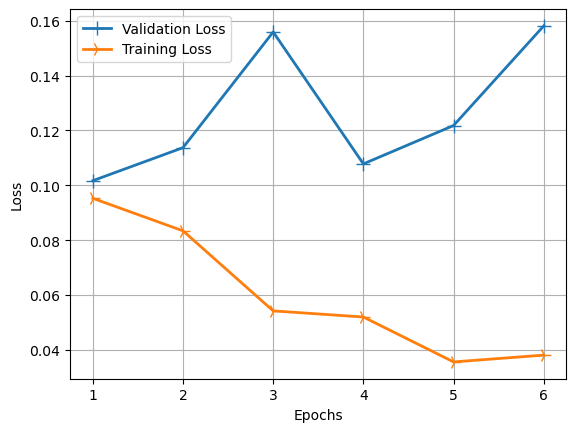

In [11]:
history_dict = model_train_result.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker='+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker='4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

### Accuracy Chart

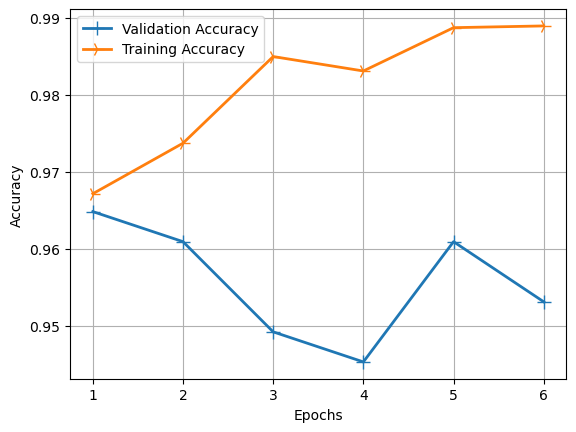

In [12]:
history_dict = model_train_result.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker='+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker='4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

## Classification Report for Validation Dataset

In [13]:
# Get model's predictions for each image in val dataset
val_pred = model.predict(val_generator, nb_val_samples // batch_size + 1)
val_pred = np.argmax(val_pred, axis=1)

# Get class names
class_names = val_generator.class_indices
class_names = {v: k for k, v in class_names.items()}
class_names = list(class_names.values())

# Get the classification report generated for val dataset
print(classification_report(y_true=val_generator.classes,
                            y_pred=val_pred, target_names=class_names))

              precision    recall  f1-score   support

          n0       0.93      0.96      0.94        26
          n1       0.97      1.00      0.98        28
          n2       1.00      1.00      1.00        27
          n3       1.00      0.87      0.93        30
          n4       0.96      1.00      0.98        26
          n5       0.93      1.00      0.97        28
          n6       0.96      0.96      0.96        26
          n7       0.93      1.00      0.97        28
          n8       1.00      0.89      0.94        27
          n9       0.92      0.92      0.92        26

    accuracy                           0.96       272
   macro avg       0.96      0.96      0.96       272
weighted avg       0.96      0.96      0.96       272



## Confusion Matrix for Validation Dataset

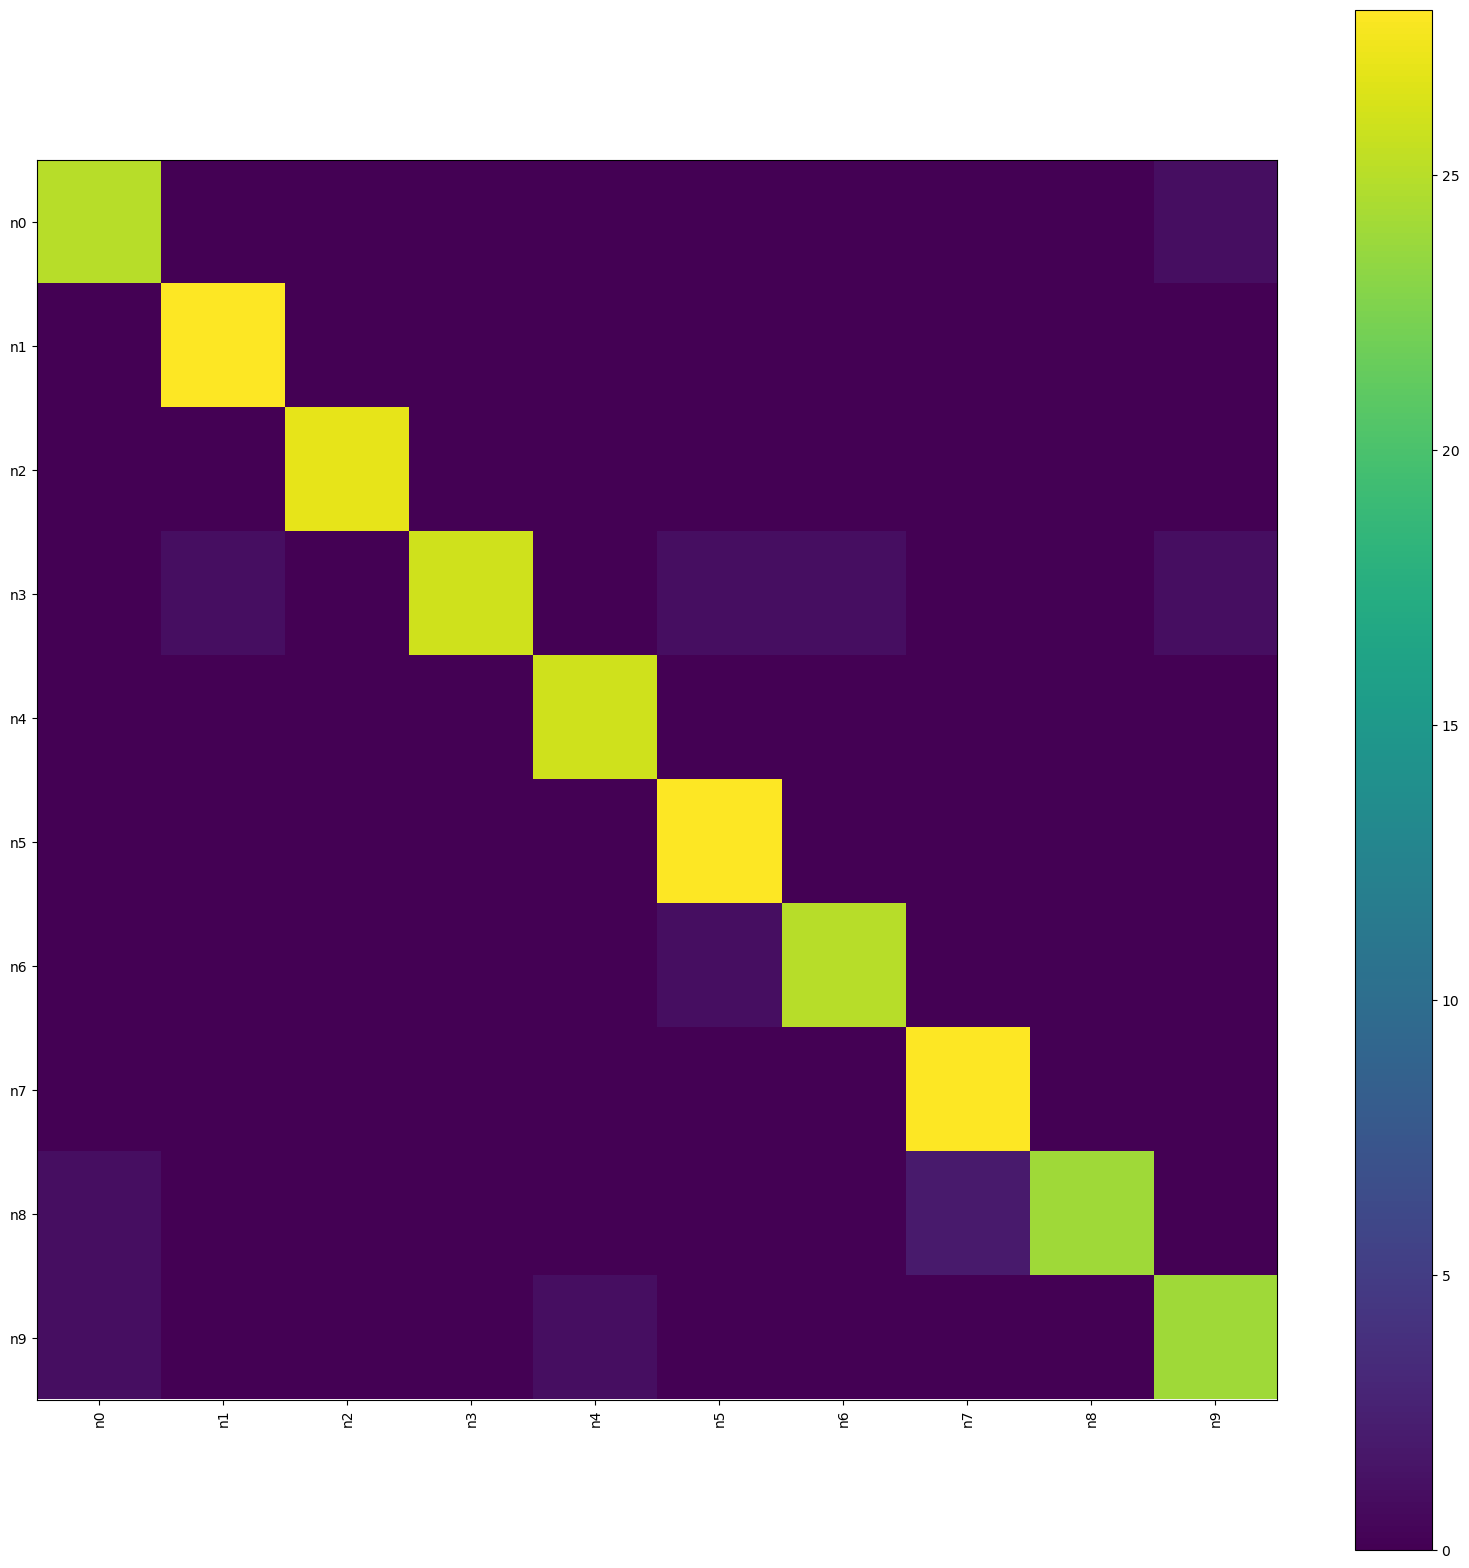

In [15]:
# Generate the confusion matrix for val dataset
cnf_matrix = confusion_matrix(y_true=val_generator.classes, y_pred=val_pred)

# Display the confusion matrix
plt.figure(figsize=(20, 20))
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(class_names))
_ = plt.xticks(tick_marks, class_names, rotation=90)
_ = plt.yticks(tick_marks, class_names)
plt.show()

# Classifier Demonstration

## Define Required Functions

In [ ]:
monkey_breeds_dict = {"[0]": "mantled_howler ",
                      "[1]": "patas_monkey",
                      "[2]": "bald_uakari",
                      "[3]": "japanese_macaque",
                      "[4]": "pygmy_marmoset ",
                      "[5]": "white_headed_capuchin",
                      "[6]": "silvery_marmoset",
                      "[7]": "common_squirrel_monkey",
                      "[8]": "black_headed_night_monkey",
                      "[9]": "nilgiri_langur"}

monkey_breeds_dict_n = {"n0": "mantled_howler ",
                        "n1": "patas_monkey",
                        "n2": "bald_uakari",
                        "n3": "japanese_macaque",
                        "n4": "pygmy_marmoset ",
                        "n5": "white_headed_capuchin",
                        "n6": "silvery_marmoset",
                        "n7": "common_squirrel_monkey",
                        "n8": "black_headed_night_monkey",
                        "n9": "nilgiri_langur"}

# Define a function that will draw model's prediction & true label over the input image
def draw_test(actual, pred, im):
    monkey = monkey_breeds_dict[str(pred)]
    BLACK = [0, 0, 0]
    expanded_image = cv2.copyMakeBorder(
        im, 80, 0, 0, 100, cv2.BORDER_CONSTANT, value=BLACK)
    cv2.putText(expanded_image, "Predicted - " + monkey, (10, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    cv2.putText(expanded_image, "Actual - " + actual, (10, 90),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow("Monkey Breeds Classifier Using MobileNetV1 - Demo", expanded_image)

# Define a function that grabs a random image from a random folder in the specified path
def get_random_image(path):
    folders = list(filter(lambda x: os.path.isdir(
        os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0, len(folders))
    path_class = folders[random_directory]
    image_class = monkey_breeds_dict_n[str(path_class)]
    file_path = path + path_class
    file_names = [f for f in os.listdir(file_path) if os.path.isfile(os.path.join(file_path, f))]
    random_file_index = np.random.randint(0, len(file_names))
    image_name = file_names[random_file_index]
    return image_class, cv2.imread(file_path + "/" + image_name)

## Run the Demonstration

In [25]:
for i in range(0, 10):
    actual, input_im = get_random_image("./Dataset/validation/")
    input_original = input_im.copy()
    input_original = cv2.resize(
        input_original, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)

    input_im = cv2.resize(input_im, (224, 224), interpolation=cv2.INTER_LINEAR)
    input_im = input_im / 255.
    input_im = input_im.reshape(1, 224, 224, 3)
    res = np.argmax(model.predict(input_im, 1, verbose=0), axis=1)
    draw_test(actual, res, input_original)
    cv2.waitKey(0)

cv2.destroyAllWindows()